In [300]:
import functools
import importlib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from bullinger import chronogram
from bullinger import cohort
from bullinger import intervals
from bullinger import plot
from bullinger import video

intervals = importlib.reload(intervals)
video = importlib.reload(video)
chronogram = importlib.reload(chronogram)
cohort = importlib.reload(cohort)
plot = importlib.reload(plot)

In [301]:
folder = '/home/olivier/dev/data/laura_codage/'
c = cohort.Cohort(folder, num_workers=20)

In [302]:
print(c.num_annotations, 'annotations in', len(c), 'videos' )

3320 annotations in 196 videos


In [303]:
c.summary

video_id  baby  duration
semester group                          
1.0      AD           52    10  5366.159
         TD           49    10  4726.794
2.0      AD           46    10  4780.752
         TD           47    10  3844.420

In [305]:
# chronogram.plot(c[0], tags=c.interaction_tags)
c.df[(c.df.tag == 'pip') & (c.df.actor != 'support')]


,actor,video_id,start,end,duration,tag,semester,baby,group,context,num_supports
305,appu pieds,Lorenzo_(6-12)_17,51.27,53.910,2.640,pip,2.0,Lorenzo,AD,sans,1.0
313,appu pieds,Lorenzo_(6-12)_17,55.40,64.078,8.678,pip,2.0,Lorenzo,AD,sans,1.0


# Comment les bébés sont-ils stimulés et comment répondent-ils ?

In [278]:
df = c.aggregate(lambda v: v.summary)
df

duration           stimulation            response          
                      mean       sem        mean       sem      mean       sem
semester group                                                                
1.0      AD     101.849635  4.263168    0.441683  0.040955  0.149508  0.027654
         TD      93.470220  3.917274    0.520146  0.040161  0.310798  0.046116
2.0      AD     100.790000  4.464595    0.496069  0.048292  0.211734  0.032572
         TD      81.190894  3.649250    0.547248  0.044832  0.449333  0.047502

<AxesSubplot:title={'center':'response'}, xlabel='semester', ylabel='response'>

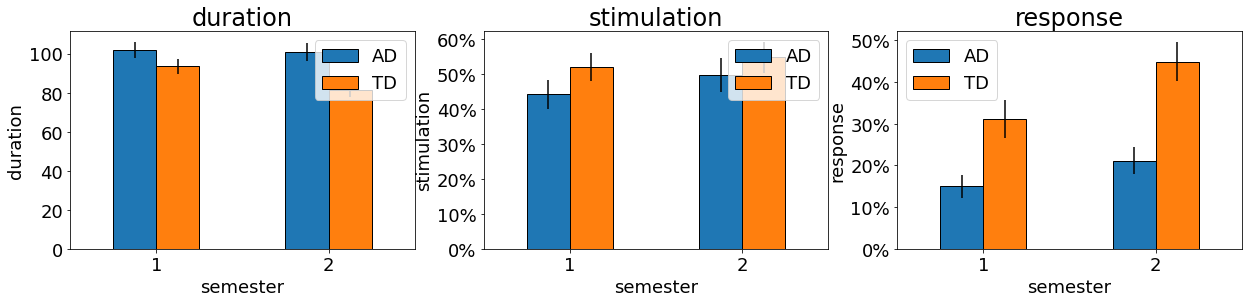

In [233]:
fig, axes = plt.subplots(1, 3, figsize=(21, 4))
plot.plot_agg(df, metric='duration', ax=axes[0], rot=0)
plot.plot_agg(df, metric='stimulation', ax=axes[1], rot=0)
plot.plot_agg(df, metric='response', ax=axes[2], rot=0)

# Le nombre d'appuis influencent-ils la reponse du bébé ?

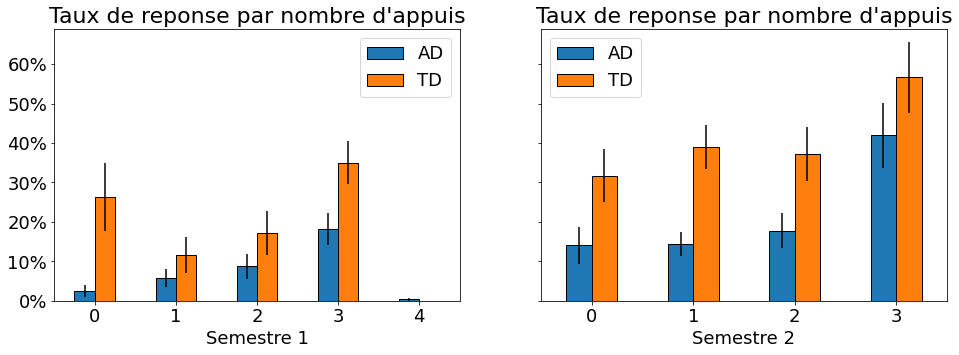

In [280]:
def supports_fn(v):
    return pd.pivot_table(v.responses_per(groupby='num_supports'), 'relative', index='num_supports').transpose().iloc[0]

axes = None
axes = plot.per_semester(c.aggregate(supports_fn), axes=axes, rot=0)
for ax in axes:
    ax.set_title('Taux de reponse par nombre d\'appuis', fontsize=22)

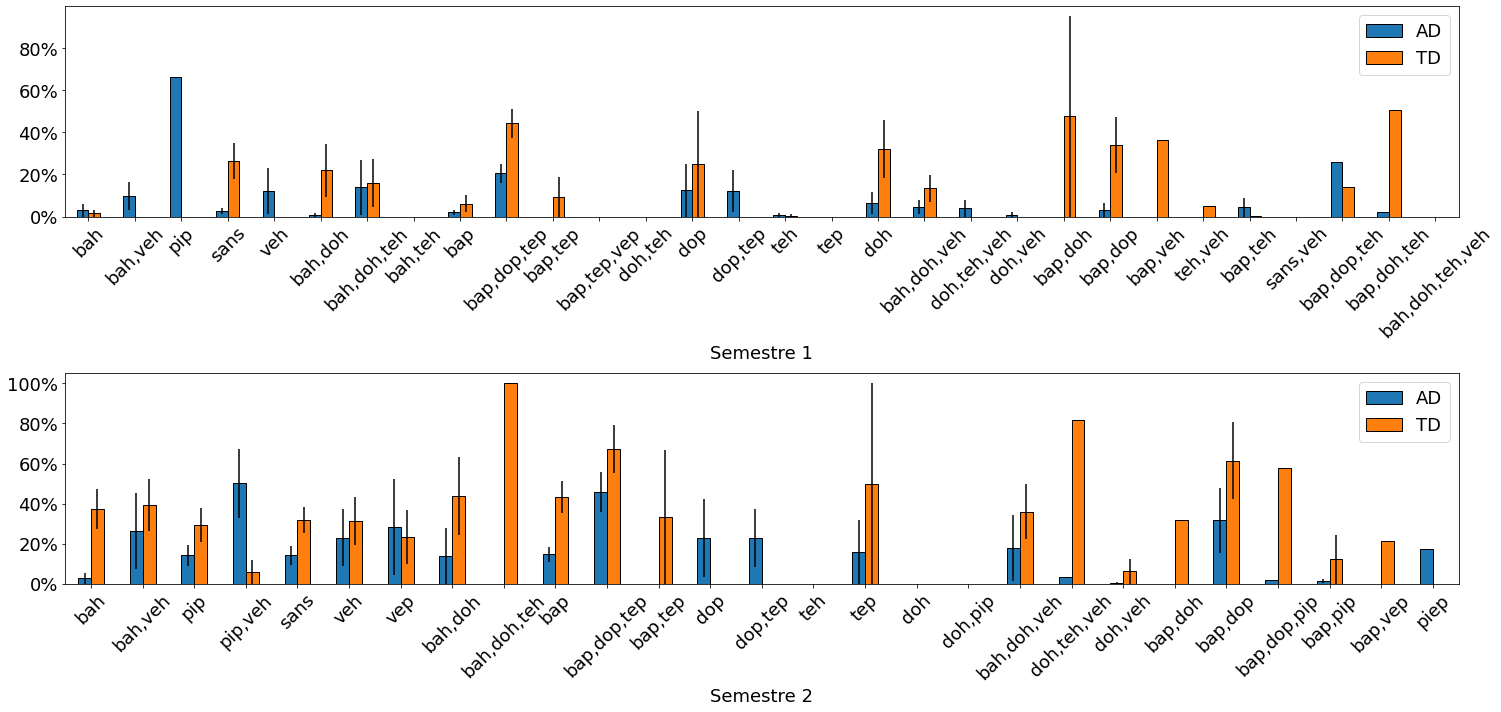

In [111]:
def full_supports_fn(v):
    return pd.pivot_table(v.responses_per(groupby='context'), 'relative', index='context').transpose().iloc[0]

df = c.aggregate(full_supports_fn).dropna(axis=1)
fig, axes = plt.subplots(2, 1, figsize=(21, 10))
plot.per_semester(df, axes=axes, rot=45)
plt.tight_layout()

# Les bebes AD sont ils moins filmes ?

<AxesSubplot:title={'center':'invisible'}, xlabel='semester', ylabel='invisible'>

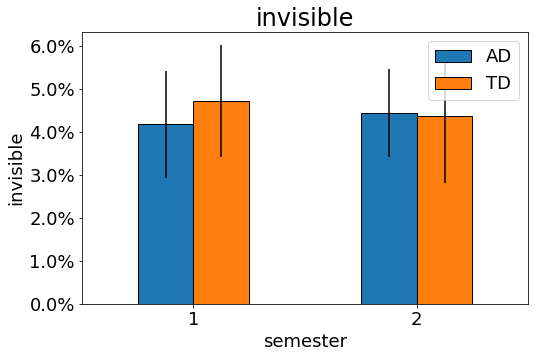

In [140]:
def invisible_time(v):
    return pd.Series({'invisible': v.df[v.df.tag == 'inv'].duration.sum() / v.duration})
    
plot.plot_agg(c.aggregate(invisible_time), 'invisible', rot=0)

num_response_rate          
                            mean       sem
semester group                            
1.0      AD             0.690625  0.056804
         TD             0.748299  0.053543
2.0      AD             0.773704  0.052871
         TD             0.894928  0.036489

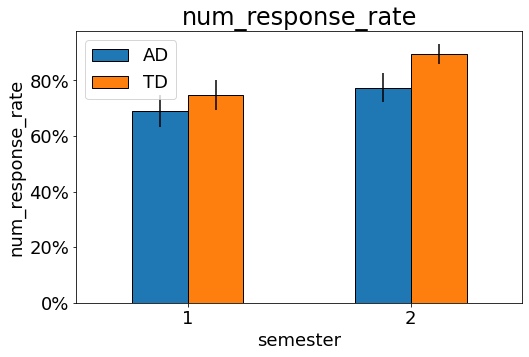

In [244]:
def count_num_responses(v: video.Video, offset: int = 10):
    if not v.stimulations.shape[0]:
        result = np.nan
    else:
        stimuls = intervals.Interval.from_dataframe(v.stimulations).expand_right(offset)
        response_i = intervals.Interval.from_dataframe(v.responses)
        count = 0
        for stim in stimuls:
            curr = intervals.Interval(*stim)#.expand_right(offset)
            count += int(not curr.intersection(response_i).empty)
        result = count / len(stimuls)
    return pd.Series({'num_response_rate': result})

plot.plot_agg(c.aggregate(functools.partial(count_num_responses, offset=10)), 'num_response_rate', rot=0)
c.aggregate(functools.partial(count_num_responses, offset=10))

num_response_rate    0.666667
dtype: float64

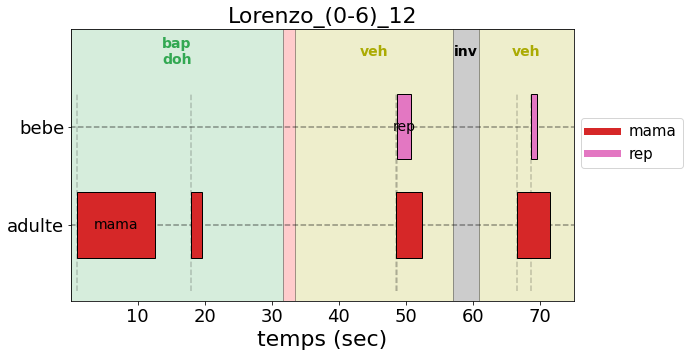

In [241]:
chronogram.plot(c[9])
count_num_responses(c[9])

num_response_rate          
                            mean       sem
semester group                            
1.0      AD             0.690625  0.056804
         TD             0.741497  0.054188
2.0      AD             0.773704  0.052871
         TD             0.894928  0.036489

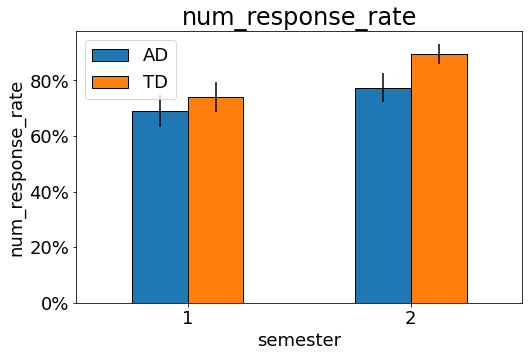

In [260]:
def count_num_responses_trimmed(v: video.Video, offset: int = 10):
    if not v.stimulations.shape[0]:
        result = np.nan
    else:
        v = v.trim_no_stimulations(offset)
        stimuls = intervals.Interval.from_dataframe(v.stimulations).expand_right(offset)
        response_i = intervals.Interval.from_dataframe(v.responses)
        count = 0
        for stim in stimuls:
            curr = intervals.Interval(*stim)#.expand_right(offset)
            count += int(not curr.intersection(response_i).empty)
        result = count / len(stimuls)
    return pd.Series({'num_response_rate': result})

df = c.aggregate(functools.partial(count_num_responses_trimmed, offset=10))
plot.plot_agg(df, 'num_response_rate', rot=0)
df

/home/olivier/dev/bullinger/venv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/olivier/dev/bullinger/bullinger/chronogram.py:122: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.array(list(yticks.keys())), fontsize=18)


<AxesSubplot:title={'center':'Lorenzo_(0-6)_12'}, xlabel='temps (sec)'>

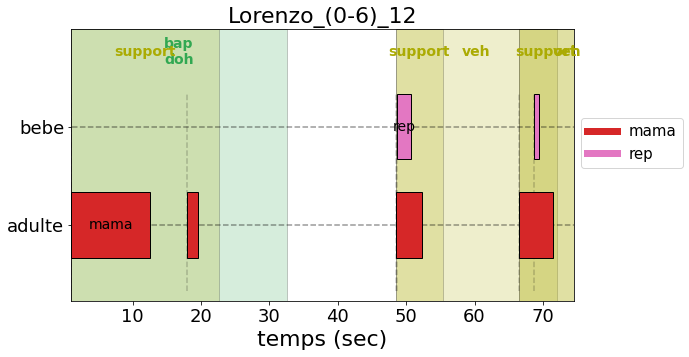

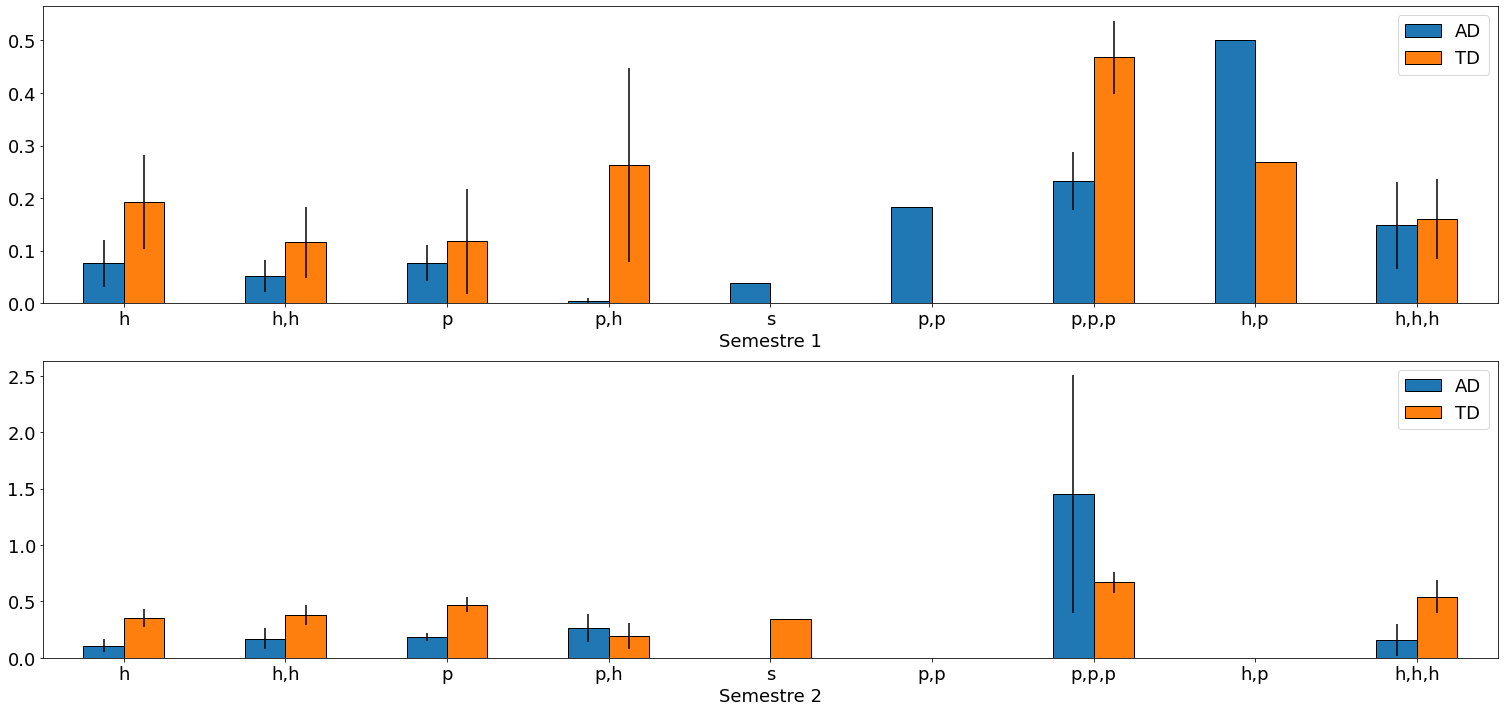

In [268]:
def support_type_fn(v):
    v.df['support_type'] = v.df.context.apply(lambda x: ','.join(a[-1] for a in x.split(',')))
    return pd.pivot_table(
        v.responses_per(groupby='support_type'), 'relative', index='support_type').transpose().iloc[0]

df = c.aggregate(support_type_fn).dropna(axis=1)
fig, axes = plt.subplots(2, 1, figsize=(21, 10))
plot.plot_per_semester(df, axes=axes, rot=0)
plt.tight_layout()

# Repeated movements

In [272]:
c.df.actor.str.startswith('rme')

array(['contexte', 'adulte', 'bebe', 'adulte bis', 'appu pieds',
       'rme bras', 'rme jambes', 'rme main', 'rme doigts'], dtype=object)